In [2]:
%matplotlib notebook
import numpy as np
import helpers
import pandas as pd
import matplotlib as mpl
import scipy.signal
import mne
from itertools import cycle
import matplotlib.pyplot as plt

mpl.rcParams['figure.max_open_warning'] = 30

select results file and get necessary parameters

In [3]:
# trialregs_dot = 0
# resfile = helpers.resultsdir + '/meg_sequential_201703011624.h5'

# trialregs_dot = 0, baseline = None
# resfile = helpers.resultsdir + '/meg_sequential_201703161743.h5'

# trialregs_dot = 5, baseline = None
# resfile = helpers.resultsdir + '/meg_sequential_201703161307.h5'

# trialregs_dot = 5
# resfile = helpers.resultsdir + '/meg_sequential_201703011927.h5'

# trialregs_dot = 0, baseline = None, choice flipped dot_x and accev
# resfile = helpers.resultsdir + '/meg_sequential_201705311314.h5'

# source GLM, trialregs_dot = 5, baseline = (-0.3, 0), choice flipped dot_x and accev
resfile = helpers.resultsdir + '/source_sequential_201706141650.h5'

# source GLM, trialregs_dot = 5, baseline = (-0.3, 0), choice flipped dot_x and accev, move_dist, sum_dot_y_prev
resfile = '/media/bitzer/Data/source_sequential_201706191442.h5.tmp'

#evoked = helpers.load_evoked_container(window=pd.read_hdf(resfile, 'window'))
evoked = helpers.load_evoked_container(window=[0, 0.9])

Reading data/meg_final_data/evoked_sfreq100.0_window0.00-0.90_mag-ave.fif ...
    Found the data of interest:
        t =       0.00 ...     890.00 ms (Unknown)
        0 CTF compensation matrices available
        nave = 480 - aspect type = 100
No baseline correction applied


plotting functions

In [4]:
stylecycler = cycle([':', '--', '-.'])
def plot_minmax_regressors(results, r_names, measure, nperm=0, mode='absmax'):
    if mode == 'max':
        ax = results.xs(measure, axis=1, level='measure').xs(0, level='permnr').max(
            level='time').plot(y=r_names);
    elif mode == 'min':
        ax = results.xs(measure, axis=1, level='measure').xs(0, level='permnr').min(
            level='time').abs().plot(y=r_names);
    elif mode == 'absmax':
        ax = results.xs(measure, axis=1, level='measure').xs(0, level='permnr').abs(
            ).max(level='time').plot(y=r_names)
    elif mode == 'absmean':
        ax = results.xs(measure, axis=1, level='measure').xs(0, level='permnr').abs(
            ).mean(level='time').plot(y=r_names)
        
    cols = [l.get_color() for l in ax.get_lines()]

    nperm += 1
    
    for perm in perms[1:nperm]:
        if mode == 'max':
            results.xs(measure, axis=1, level='measure').xs(perm, level='permnr').max(
                level='time').plot(y=r_names, ax=ax, 
                style=[next(stylecycler)] * len(r_names))
        elif mode == 'min':
            results.xs(measure, axis=1, level='measure').xs(perm, level='permnr').min(
                level='time').abs().plot(y=r_names, ax=ax, 
                style=[next(stylecycler)] * len(r_names))
        elif mode == 'absmax':
            results.xs(measure, axis=1, level='measure').xs(perm, level='permnr').abs(
                ).max(level='time').plot(y=r_names, ax=ax, 
                style=[next(stylecycler)] * len(r_names))
        elif mode == 'absmean':
            results.xs(measure, axis=1, level='measure').xs(perm, level='permnr').abs(
                ).mean(level='time').plot(y=r_names, ax=ax, 
                style=[next(stylecycler)] * len(r_names))

    lines = ax.get_lines()
    for i in range(len(r_names)):
        col = lines[i].get_color()
        for perm in perms[1:nperm]:
            lines[i + perm * len(r_names)].set_color(col)

def show_topology_at_peaks(results, r_name, measure, mode='absmax', order=4, vmin=-.1, vmax=.1):
    if mode == 'absmax':
        data = results.loc[0, (measure, r_name)].abs().max(level='time')
    elif mode == 'absmean':
        data = results.loc[0, (measure, r_name)].abs().mean(level='time')
    elif mode == 'max':
        data = results.loc[0, (measure, r_name)].max(level='time')
    else:
        data = results.loc[0, (measure, r_name)].min(level='time').abs()
    
    plt.figure()
    ax = data.plot(title=measure);
    
    # identify local maxima
    times = data.index[scipy.signal.argrelextrema(data.values, 
                                                  np.greater, order=order)] / 1000
    
    data = results.loc[0, (measure, r_name)]
    ev = mne.EvokedArray(data.values.reshape(102, data.index.levels[1].size), 
                         evoked.info, tmin=data.index.levels[1][0], 
                         nave=480*5, comment=r_name)
    
    fig = ev.plot_topomap(times, scale=1, vmin=vmin, vmax=vmax, image_interp='nearest', 
                          title=r_name+' aligned to dot onset', unit=measure, 
                          outlines='skirt');
    

def plot_single_signal(fl_data, sl_data, label, r_name, ax=None):
    dat = fl_data.loc[(0, label, slice(None)), 
                      (slice(None), 'beta', r_name)]
    times = dat.index.get_level_values('time')
    
    if ax is None:
        fig, ax = plt.subplots()
        
    l = ax.plot(times, dat, color='.7', label='single subjects')
    l1 = ax.plot(times, sl_data.loc[(slice(1,3), label, slice(None)), ('mean', r_name)]
                               .reset_index('permnr')
                               .pivot(columns='permnr'), 
                 ':k', label='mean (permuted data)')
    l2 = ax.plot(times, sl_data.loc[(0, label, slice(None)), ('mean', r_name)], 
                 'k', lw=2, label='mean')
    
    ax.legend([l[0], l1[0], l2[0]], ['single subjects', 'mean (permuted data)', 'mean']);
    ax.set_title(label)
    ax.set_xlabel('time from dot onset (ms)')
    ax.set_ylabel('beta of ' + r_name + ' (z)')

# Second level analysis

this scales the betas by their standard error and then averages across subjects to get the second level mean

In [22]:
first_level = pd.read_hdf(resfile, 'first_level')
flt = (  first_level.xs('beta', level='measure', axis=1) 
       / first_level.xs('bse', level='measure', axis=1))
second_level = pd.concat([flt.mean(level='regressor', axis=1), 
                          flt.std(level='regressor', axis=1)], keys=['mean', 'std'], names=['measure'], axis=1)

del first_level, flt
perms = second_level.index.levels[0]

standard analysis: average betas across subjects to get the second level mean

In [85]:
first_level = pd.read_hdf(resfile, 'first_level')
second_level = pd.read_hdf(resfile, 'second_level')
perms = second_level.index.levels[0]

# Note that these are not exactly the t-values underlying the negative log10 p-values 
# stored in second_level, because scipy.stats uses a different denominator when 
# computing variances and standard deviations than the default used by numpy 
# (N-1 in scipy.stats vs. N in numpy default).
tvals = (second_level.xs('mean', axis=1, level='measure')  / 
         second_level.xs('std', axis=1, level='measure') * np.sqrt(34))
tvals['accev'] = -tvals['accev']

In [139]:
absmean = tvals.xs(0, level='permnr').abs().mean(level='time')

<IPython.core.display.Javascript object>


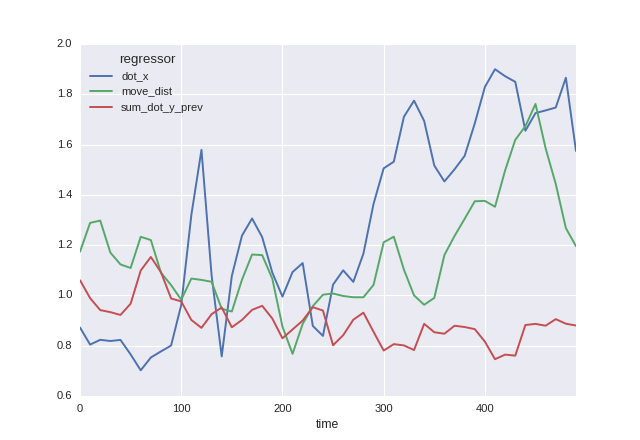

In [145]:
absmean.plot.line(y=['dot_x', 'move_dist', 'sum_dot_y_prev']);

In [169]:
tvals.loc[(0, slice(None), 450), 'move_dist'].abs().sort_values(ascending=False)

permnr  label           time
0       R_43_ROI-rh     450     5.391445
        L_IFJa_ROI-lh   450     5.178301
        L_PEF_ROI-lh    450     4.970182
        R_FOP1_ROI-rh   450     4.929187
        R_p32_ROI-rh    450     4.785686
        R_10r_ROI-rh    450     4.687977
        R_MBelt_ROI-rh  450     4.444476
        R_MT_ROI-rh     450     4.372303
        L_2_ROI-lh      450     4.318935
        L_PFt_ROI-lh    450     4.297791
        L_3b_ROI-lh     450     4.262265
        R_52_ROI-rh     450     4.259726
        L_V3B_ROI-lh    450     4.250852
        R_a24_ROI-rh    450     4.184845
        L_FOP2_ROI-lh   450     4.181755
        R_10v_ROI-rh    450     4.112343
        R_PI_ROI-rh     450     4.052435
        L_AIP_ROI-lh    450     4.024541
        R_TA2_ROI-rh    450     3.998385
        R_AVI_ROI-rh    450     3.753516
        L_31a_ROI-lh    450     3.704111
        L_5mv_ROI-lh    450     3.672138
        R_s32_ROI-rh    450     3.656987
        R_TPOJ2_ROI-rh  450 

### describe genuine regressors

In [6]:
measure = 'mean'

second_level.xs(measure, axis=1, level='measure').xs(0, level='permnr').describe()

regressor,abs_dot_x,abs_dot_y,accev,accev_cflip,accsur_pca,dot_x,dot_x_cflip,dot_y,entropy,intercept,move_dist,response,sum_dot_y_prev,trial_time
count,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000
mean,0.000066,-0.000155,-0.000021,0.000147,-0.000046,0.000088,0.000032,0.000054,-0.000157,0.001026,0.000283,-0.000141,-0.000156,-0.000281
std,0.004938,0.004318,0.009830,0.005375,0.003920,0.008021,0.003810,0.004433,0.009871,0.023811,0.007196,0.008337,0.004908,0.014960
min,-0.026737,-0.022992,-0.054404,-0.025904,-0.021309,-0.056959,-0.019595,-0.029174,-0.046640,-0.109075,-0.032092,-0.049993,-0.035591,-0.065807
25%,-0.002933,-0.002706,-0.004899,-0.003282,-0.002422,-0.003335,-0.002323,-0.002389,-0.006097,-0.012269,-0.004049,-0.005109,-0.003189,-0.009887
50%,0.000113,-0.000121,-0.000046,0.000128,0.000032,0.000053,-0.000007,-0.000020,-0.000167,0.001369,0.000278,-0.000152,-0.000141,0.000038
75%,0.003096,0.002391,0.005029,0.003507,0.002383,0.003430,0.002424,0.002406,0.005842,0.015249,0.004576,0.004839,0.002841,0.009232
max,0.024671,0.021556,0.051105,0.022641,0.016583,0.051364,0.017650,0.033640,0.045609,0.109145,0.033507,0.040207,0.039449,0.071288


### describe regressors of first permutation

In [7]:
second_level.xs(measure, axis=1, level='measure').xs(1, level='permnr').describe()

regressor,abs_dot_x,abs_dot_y,accev,accev_cflip,accsur_pca,dot_x,dot_x_cflip,dot_y,entropy,intercept,move_dist,response,sum_dot_y_prev,trial_time
count,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000
mean,-0.000030,-0.000018,-0.000024,-0.000039,-0.000005,-0.000013,0.000004,-0.000014,0.000202,0.001023,0.000097,0.000048,0.000041,-0.000023
std,0.003997,0.003626,0.003376,0.003926,0.003850,0.003401,0.003612,0.003232,0.009690,0.023652,0.006987,0.007638,0.003179,0.007173
min,-0.021248,-0.016318,-0.018440,-0.017231,-0.020683,-0.017072,-0.016383,-0.014027,-0.043187,-0.109593,-0.031785,-0.034846,-0.013054,-0.031580
25%,-0.002478,-0.002239,-0.002151,-0.002438,-0.002406,-0.002122,-0.002309,-0.002033,-0.005872,-0.011836,-0.004040,-0.004770,-0.001970,-0.004532
50%,-0.000010,0.000018,-0.000027,-0.000048,0.000019,-0.000011,0.000014,-0.000013,0.000178,0.001359,0.000081,0.000036,0.000038,-0.000063
75%,0.002403,0.002225,0.002100,0.002377,0.002352,0.002101,0.002236,0.002008,0.006216,0.014907,0.004156,0.004815,0.002014,0.004438
max,0.022815,0.017528,0.016046,0.017374,0.018331,0.017955,0.017735,0.018012,0.039951,0.106541,0.030719,0.038463,0.013269,0.032677


## Show evolution of max (across channels) through the trial

principle regressors of interest

<IPython.core.display.Javascript object>


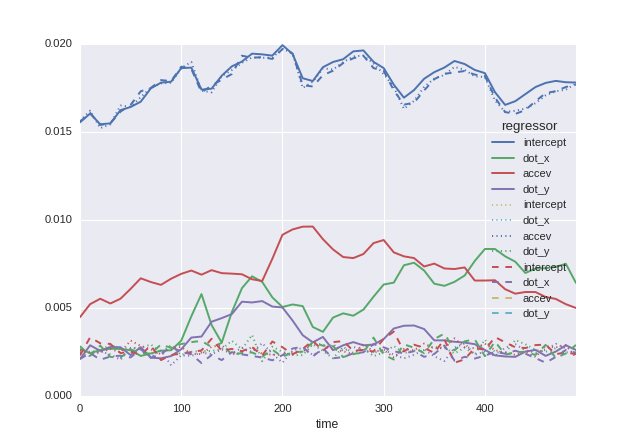

In [8]:
reg = ['intercept', 'dot_x', 'accev', 'dot_y']
measure = 'mean'

plot_minmax_regressors(second_level, reg, measure, nperm=2, mode='absmean')

surprise regressors

<IPython.core.display.Javascript object>


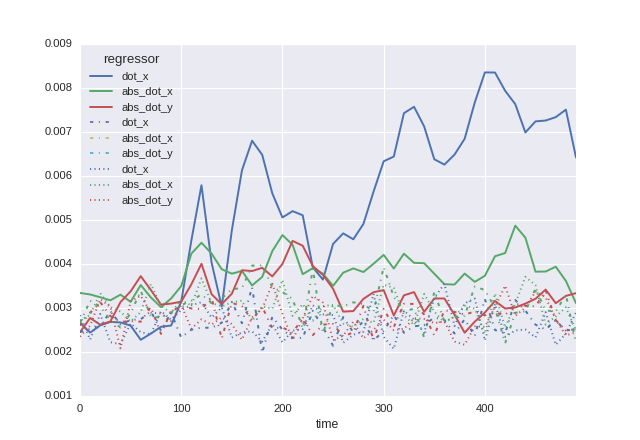

In [9]:
plot_minmax_regressors(second_level, ['dot_x', 'abs_dot_x', 'abs_dot_y'], 
                       measure, nperm=2, mode='absmean')

trial regressors

<IPython.core.display.Javascript object>


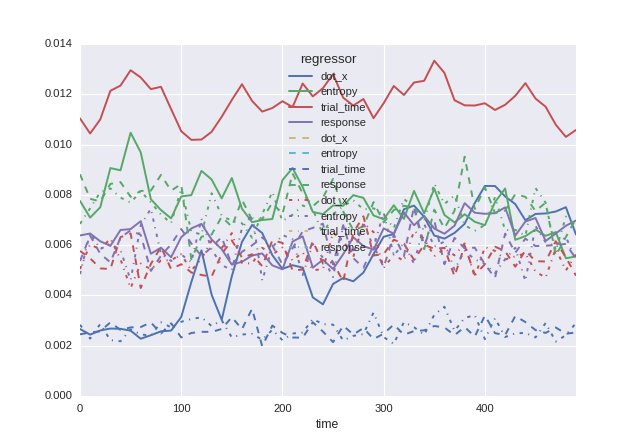

In [10]:
plot_minmax_regressors(second_level, ['dot_x', 'entropy', 'trial_time', 'response'], 
                       measure, nperm=2, mode='absmean')

choice flipped evidence regressors

<IPython.core.display.Javascript object>


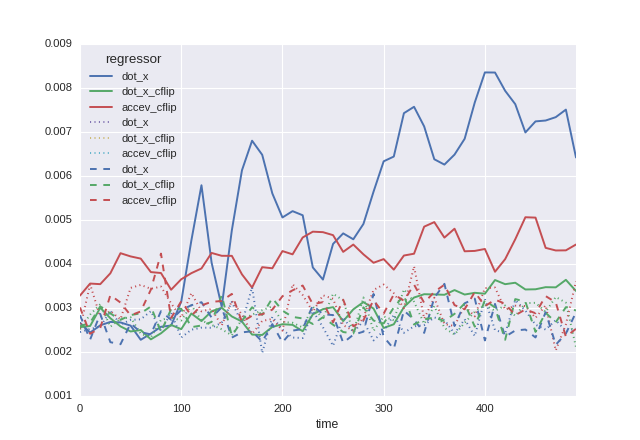

In [11]:
plot_minmax_regressors(second_level, ['dot_x', 'dot_x_cflip', 'accev_cflip'], 
                       measure, nperm=2, mode='absmean')

purely perceptual regressors

<IPython.core.display.Javascript object>


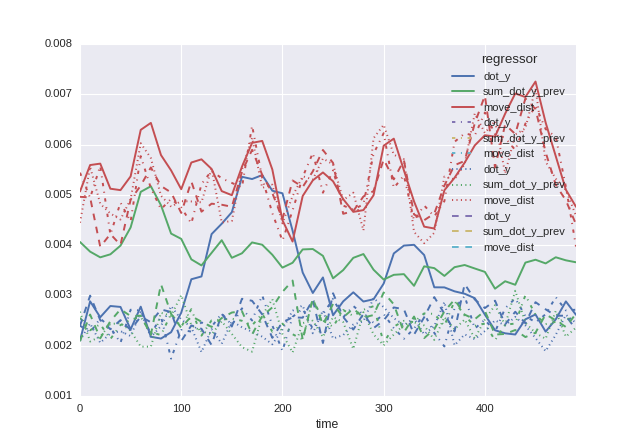

In [123]:
plot_minmax_regressors(second_level, ['dot_y', 'sum_dot_y_prev', 'move_dist'], 
                       measure, nperm=3, mode='absmean')

### Is the effect consistent across permutations within labels?

<IPython.core.display.Javascript object>


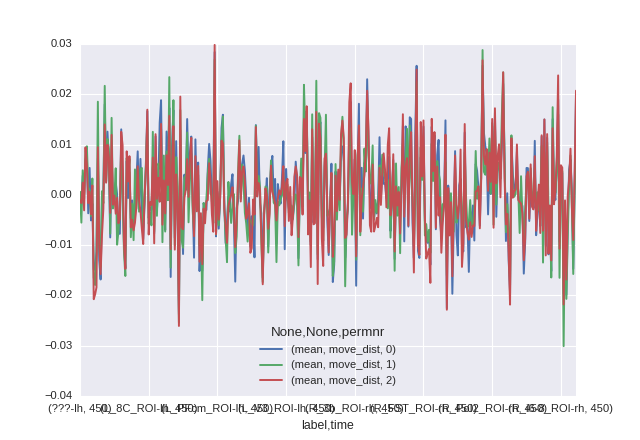

In [126]:
md = second_level.loc[(slice(0, 2), slice(None), 450), (measure, 'move_dist')].reset_index(level='permnr').pivot(columns='permnr')
md.plot();

In [134]:
md.xs(0, level='permnr', axis=1).abs().sort_values(('mean', 'move_dist'), ascending=False)

,,mean
,,move_dist
label,time,
L_PEF_ROI-lh,450,0.028395
R_PI_ROI-rh,450,0.025690
R_FOP1_ROI-rh,450,0.025663
L_IFJa_ROI-lh,450,0.023755
R_52_ROI-rh,450,0.022989
R_MBelt_ROI-rh,450,0.022558
R_STSda_ROI-rh,450,0.022110
R_p32_ROI-rh,450,0.019876


### Checking design matrix directly

In [53]:
import subject_DM

In [56]:
dots = np.arange(1, 6)

r_names = ['abs_dot_y', 'abs_dot_x', 'dot_y', 'dot_x', 'entropy', 'trial_time', 
           'intercept', 'accev', 'accsur_pca', 'response', 'dot_x_cflip', 
           'accev_cflip', 'move_dist', 'sum_dot_y_prev']
R = len(r_names)

subjects = first_level.columns.levels[0]

times = first_level.index.levels[2]

def get_data_times(t0):
    """Returns the times relative to a t0 when an effect of the chosen dots 
        can be expected. t0 is in ms!
    """
    datat = t0 + (dots - 1) * helpers.dotdt * 1000
    
    assert np.all(datat <= times[-1]), ("The times where you are looking for an "
                  "effect have to be within the specified time window")
             
    return times[[np.abs(times - t).argmin() for t in datat]]

if 'RT' in r_names:
    DM = subject_DM.get_trial_DM(dots, r_names=r_names)
else:
    DM = subject_DM.get_trial_DM(dots, r_names=r_names+['RT'])
    
DM = DM.loc(axis=0)[subjects, :]

if 'RT' not in r_names:
    del DM['RT']
    
dotregs = []
for col in DM.columns:
    if col[-2:] == '_%d' % dots[0]:
        dotregs.append(col[:-2])
otherregs = list(np.setdiff1d(r_names, dotregs))
        
def get_dot_DM(DM, dot):
    rn = list(map(lambda s: s+'_%d' % dot, dotregs))
    DMdot = DM[otherregs + rn]
    return DMdot.rename(columns=dict(zip(rn, dotregs)))

DM = pd.concat([get_dot_DM(DM, dot) for dot in dots], keys=dots, 
                names=['dot'] + DM.index.names)
DM = DM.reorder_levels(['subject', 'trial', 'dot']).sort_index()
DM.sort_index(axis=1, inplace=True)

DM = (DM - DM.mean()) / DM.std()
# intercept will be nan, because it has no variance
DM['intercept'] = 1

In [61]:
import seaborn as sns

In [155]:
DM.loc[(2, slice(1, 3), 1), 'sum_dot_y_prev']

subject  trial  dot
2        1      1     -0.020835
         2      1     -0.020835
         3      1     -0.020835
Name: sum_dot_y_prev, dtype: float64

In [148]:
DM.loc[2].std(level='dot')

,abs_dot_x,abs_dot_y,accev,accev_cflip,accsur_pca,dot_x,dot_x_cflip,dot_y,entropy,intercept,move_dist,response,sum_dot_y_prev,trial_time
dot,,,,,,,,,,,,,,
1,0.816318,0.934992,0.000000,0.402310,0.557756,0.872308,0.886011,1.042358,0.76622,0.0,0.000000,0.997228,0.000000,1.001037
2,0.758814,1.038975,0.794823,0.918431,0.934965,0.764393,0.760605,0.921671,0.76622,0.0,0.702335,0.997228,0.718694,1.001037
3,1.010969,1.018719,1.071952,1.138649,1.090333,0.981036,0.966878,1.047648,0.76622,0.0,0.902437,0.997228,1.040999,1.001037
4,0.913488,0.946563,1.166634,1.123232,0.933015,0.919381,0.949198,0.974006,0.76622,0.0,0.911031,0.997228,1.255307,1.001037
5,1.217336,1.027637,1.105347,1.091116,1.128034,1.362889,1.333965,0.997176,0.76622,0.0,0.872522,0.997228,1.351794,1.001037


<IPython.core.display.Javascript object>


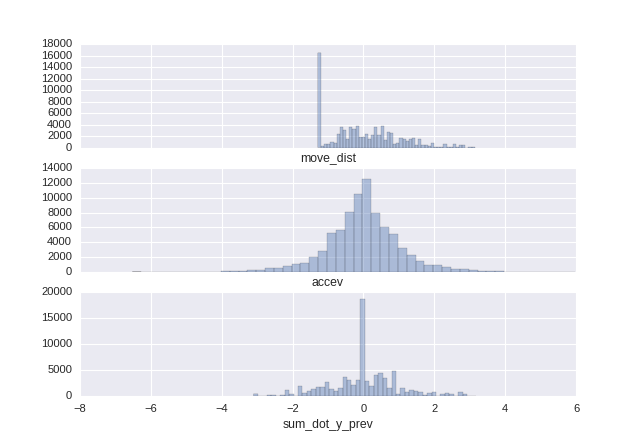

In [160]:
fig, axes = plt.subplots(3, 1, sharex=True)
sns.distplot(DM.move_dist, kde=False, ax=axes[0]);
sns.distplot(DM.accev.dropna(), kde=False, ax=axes[1]);
sns.distplot(DM.sum_dot_y_prev, kde=False, ax=axes[2]);

### Checking permutation algorithm

In [28]:
T = 8
N = 6
permutation = np.arange(N * T).reshape([N, T])
permutation

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 8,  9, 10, 11, 12, 13, 14, 15],
       [16, 17, 18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29, 30, 31],
       [32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47]])

In [29]:
np.random.shuffle(permutation[:, 0])
permutation

array([[24,  1,  2,  3,  4,  5,  6,  7],
       [ 8,  9, 10, 11, 12, 13, 14, 15],
       [32, 17, 18, 19, 20, 21, 22, 23],
       [40, 25, 26, 27, 28, 29, 30, 31],
       [ 0, 33, 34, 35, 36, 37, 38, 39],
       [16, 41, 42, 43, 44, 45, 46, 47]])

In [30]:
np.random.shuffle(permutation[:, 1])
permutation

array([[24, 25,  2,  3,  4,  5,  6,  7],
       [ 8,  1, 10, 11, 12, 13, 14, 15],
       [32, 41, 18, 19, 20, 21, 22, 23],
       [40, 17, 26, 27, 28, 29, 30, 31],
       [ 0,  9, 34, 35, 36, 37, 38, 39],
       [16, 33, 42, 43, 44, 45, 46, 47]])

In [31]:
np.random.shuffle(permutation[:, 2])
permutation

array([[24, 25,  2,  3,  4,  5,  6,  7],
       [ 8,  1, 10, 11, 12, 13, 14, 15],
       [32, 41, 26, 19, 20, 21, 22, 23],
       [40, 17, 42, 27, 28, 29, 30, 31],
       [ 0,  9, 34, 35, 36, 37, 38, 39],
       [16, 33, 18, 43, 44, 45, 46, 47]])

In [32]:
np.random.shuffle(permutation[:, 3])
permutation

array([[24, 25,  2, 19,  4,  5,  6,  7],
       [ 8,  1, 10, 27, 12, 13, 14, 15],
       [32, 41, 26, 35, 20, 21, 22, 23],
       [40, 17, 42, 43, 28, 29, 30, 31],
       [ 0,  9, 34, 11, 36, 37, 38, 39],
       [16, 33, 18,  3, 44, 45, 46, 47]])

In [33]:
permutation.flatten()

array([24, 25,  2, 19,  4,  5,  6,  7,  8,  1, 10, 27, 12, 13, 14, 15, 32,
       41, 26, 35, 20, 21, 22, 23, 40, 17, 42, 43, 28, 29, 30, 31,  0,  9,
       34, 11, 36, 37, 38, 39, 16, 33, 18,  3, 44, 45, 46, 47])

In [34]:
data = np.round(np.random.rand(N, T) * 1000) / 100
data

array([[ 5.69,  7.25,  3.05,  9.26,  0.35,  5.2 ,  0.61,  3.61],
       [ 7.94,  8.06,  0.74,  6.04,  8.81,  3.2 ,  5.07,  3.66],
       [ 9.09,  2.14,  8.27,  0.33,  9.63,  5.82,  4.14,  9.78],
       [ 4.92,  5.97,  6.35,  1.45,  4.76,  9.46,  5.88,  0.3 ],
       [ 0.09,  7.  ,  8.83,  4.88,  1.81,  5.96,  3.35,  5.25],
       [ 0.77,  8.59,  6.23,  1.99,  0.89,  7.86,  4.63,  5.85]])

In [35]:
data.flatten()

array([ 5.69,  7.25,  3.05,  9.26,  0.35,  5.2 ,  0.61,  3.61,  7.94,
        8.06,  0.74,  6.04,  8.81,  3.2 ,  5.07,  3.66,  9.09,  2.14,
        8.27,  0.33,  9.63,  5.82,  4.14,  9.78,  4.92,  5.97,  6.35,
        1.45,  4.76,  9.46,  5.88,  0.3 ,  0.09,  7.  ,  8.83,  4.88,
        1.81,  5.96,  3.35,  5.25,  0.77,  8.59,  6.23,  1.99,  0.89,
        7.86,  4.63,  5.85])

In [40]:
permutation

array([[24, 25,  2, 19,  4,  5,  6,  7],
       [ 8,  1, 10, 27, 12, 13, 14, 15],
       [32, 41, 26, 35, 20, 21, 22, 23],
       [40, 17, 42, 43, 28, 29, 30, 31],
       [ 0,  9, 34, 11, 36, 37, 38, 39],
       [16, 33, 18,  3, 44, 45, 46, 47]])

In [39]:
data.flatten()[permutation.flatten()]

array([ 4.92,  5.97,  3.05,  0.33,  0.35,  5.2 ,  0.61,  3.61,  7.94,
        7.25,  0.74,  1.45,  8.81,  3.2 ,  5.07,  3.66,  0.09,  8.59,
        6.35,  4.88,  9.63,  5.82,  4.14,  9.78,  0.77,  2.14,  6.23,
        1.99,  4.76,  9.46,  5.88,  0.3 ,  5.69,  8.06,  8.83,  6.04,
        1.81,  5.96,  3.35,  5.25,  9.09,  7.  ,  8.27,  9.26,  0.89,
        7.86,  4.63,  5.85])

In [41]:
data.flatten()[permutation.flatten()].reshape(N, T)

array([[ 4.92,  5.97,  3.05,  0.33,  0.35,  5.2 ,  0.61,  3.61],
       [ 7.94,  7.25,  0.74,  1.45,  8.81,  3.2 ,  5.07,  3.66],
       [ 0.09,  8.59,  6.35,  4.88,  9.63,  5.82,  4.14,  9.78],
       [ 0.77,  2.14,  6.23,  1.99,  4.76,  9.46,  5.88,  0.3 ],
       [ 5.69,  8.06,  8.83,  6.04,  1.81,  5.96,  3.35,  5.25],
       [ 9.09,  7.  ,  8.27,  9.26,  0.89,  7.86,  4.63,  5.85]])

### Checking definition of move_dist regressor

In [14]:
import regressors

Loaded entropies from file (S=15000, entropy_bins=50)!
Loaded dot-level measures from file (S=2000, Smin=20)!


In [17]:
regressors.trial_dot[['move_dist', 'dot_x', 'dot_y']]

move_dist  dot_x  dot_y
trial dot                          
1     1      0.000000   12.0   -7.0
      2     44.000000  -32.0   -7.0
      3    125.227792   87.0   32.0
      4    124.169239   24.0  -75.0
      5    175.376737 -135.0   -1.0
      6    141.014184    6.0    1.0
      7     82.975900   87.0  -17.0
      8    110.353976   60.0   90.0
      9    169.162644  -10.0  -64.0
      10   122.588743   98.0   -6.0
      11    42.449971   57.0  -17.0
      12   117.647779  -47.0   38.0
      13   102.615788   34.0  101.0
      14    61.400326   95.0   94.0
      15    77.006493   18.0   93.0
      16    79.812280   67.0   30.0
      17    50.537115   22.0    7.0
      18   101.710373  -29.0  -81.0
      19    20.615528  -34.0 -101.0
      20    21.931712  -50.0  -86.0
      21   153.792067    4.0   58.0
      22    53.075418  -32.0   97.0
      23    87.235314   45.0   56.0
      24   196.573142  -34.0 -124.0
      25   208.655218   50.0   67.0
2     1      0.000000  -67.0    4.0
      2    155.116086   88.0   -2.0
      3     86.005814   54.0  -81.0
      4     82.680106   10.0  -11.0
      5    151.528875 -135.0  -55.0
...               ...    ...    ...
479   21   163.893258   28.0  -74.0
      22    12.206556   21.0  -64.0
      23   117.038455   24.0 -181.0
      24   192.782261  -14.0    8.0
      25    65.299311   36.0   50.0
480   1      0.000000   70.0 -126.0
      2    208.887530  -27.0   59.0
      3    141.481448  109.0   98.0
      4    206.206207  -16.0  -66.0
      5     96.602277   70.0  -22.0
      6    152.397507  -79.0   10.0
      7     67.230945  -21.0  -24.0
      8     61.554854   24.0   18.0
      9     28.178006   49.0   31.0
      10   166.364059   60.0 -135.0
      11    36.235342   43.0 -167.0
      12   214.009346   41.0   47.0
      13   101.788997  126.0   -9.0
      14   140.356688   34.0 -115.0
      15   145.413204  -35.0   13.0
      16   119.339851  -44.0 -106.0
      17    66.211781   16.0  -78.0
      18   120.619236   -9.0   40.0
      19    41.146081  -27.0   77.0
      20   159.831161   88.0  -34.0
      21   197.800404  -31.0  124.0
      22   147.597425   37.0   -7.0
      23    49.244289   80.0   17.0
      24    67.601775   89.0  -50.0
      25   195.685973  -13.0  117.0

[12000 rows x 3 columns]

<IPython.core.display.Javascript object>


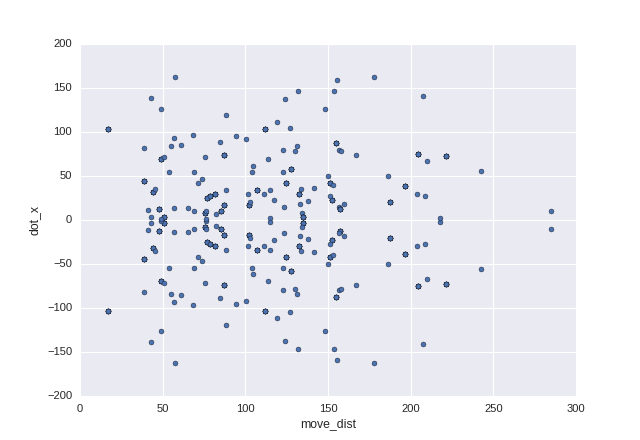

In [90]:
#fig, ax = plt.subplots()
regressors.trial_dot.loc[(slice(None), 2), ['move_dist', 'dot_x']].plot.scatter('move_dist', 'dot_x')

## Check distribution of a signal signal across time and subjects

<IPython.core.display.Javascript object>


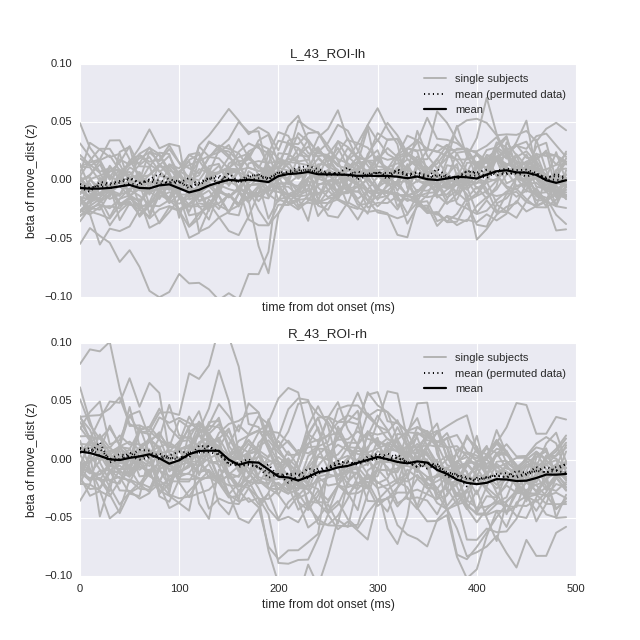

In [173]:
r_name = 'move_dist'
area = '43'
fig, axes = plt.subplots(2, 1, sharey=True, sharex=True, figsize=[8, 8])
plot_single_signal(first_level, second_level, 'L_%s_ROI-lh'%area, r_name, axes[0])
plot_single_signal(first_level, second_level, 'R_%s_ROI-rh'%area, r_name, axes[1])
axes[1].set_ylim([-0.1, 0.1]);

<IPython.core.display.Javascript object>


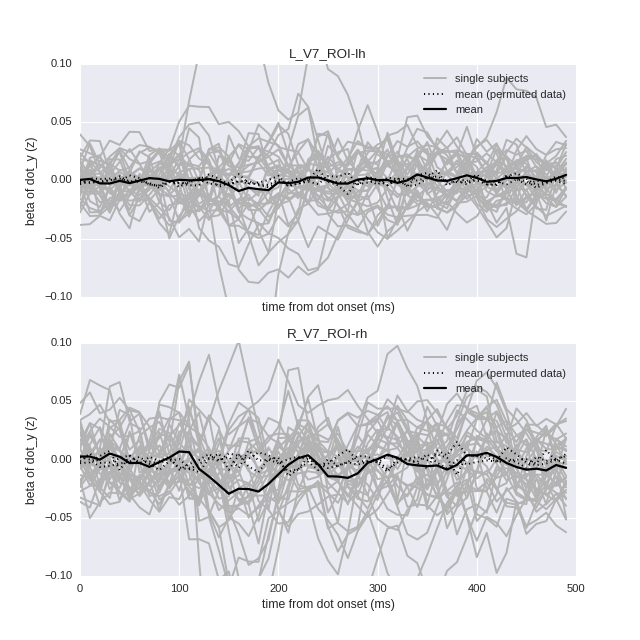

In [53]:
r_name = 'dot_y'
#area = 'LIPd'
fig, axes = plt.subplots(2, 1, sharey=True, sharex=True, figsize=[8, 8])
plot_single_signal(first_level, second_level, 'L_%s_ROI-lh'%area, r_name, axes[0])
plot_single_signal(first_level, second_level, 'R_%s_ROI-rh'%area, r_name, axes[1])
axes[1].set_ylim([-0.1, 0.1]);

## Investigate topography (without baseline correction)

<IPython.core.display.Javascript object>


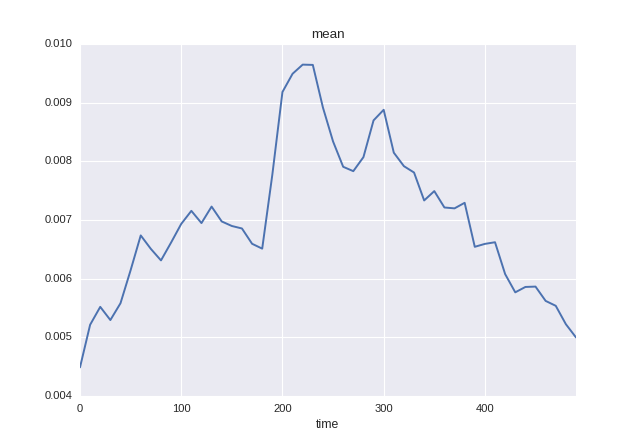

ValueError: total size of new array must be unchanged

In [75]:
show_topology_at_peaks(second_level, 'accev', 'mean', mode='absmean', order=3)

<IPython.core.display.Javascript object>


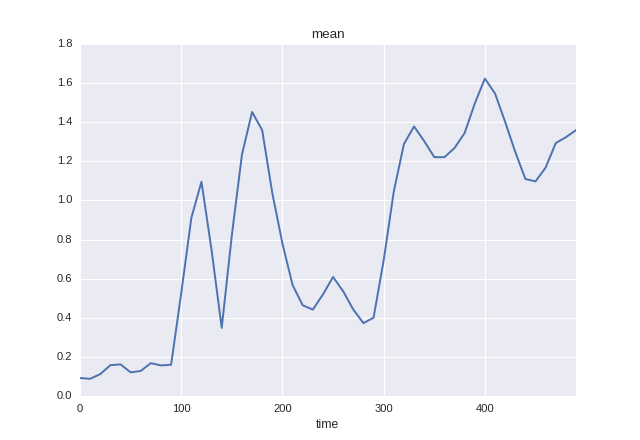

<IPython.core.display.Javascript object>


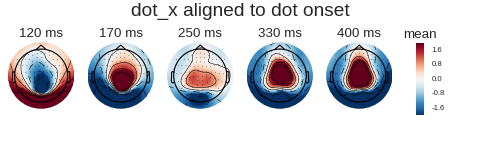

In [17]:
show_topology_at_peaks(second_level, 'dot_x', 'mean', mode='absmean', order=3, vmin=-2, vmax=2)

<IPython.core.display.Javascript object>


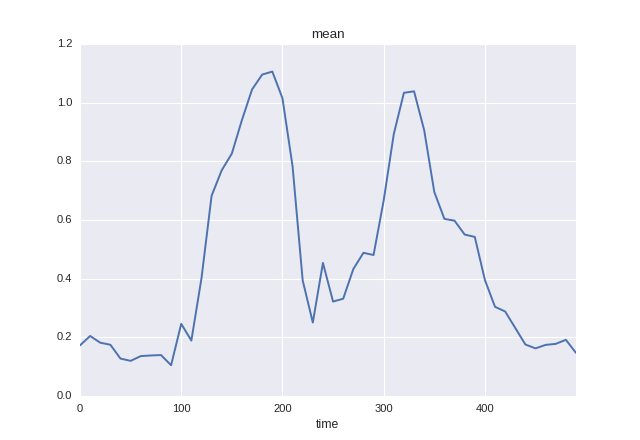

<IPython.core.display.Javascript object>


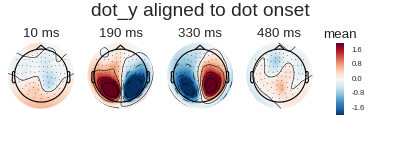

In [18]:
show_topology_at_peaks(second_level, 'dot_y', 'mean', mode='absmean', vmin=-2, vmax=2)

<IPython.core.display.Javascript object>


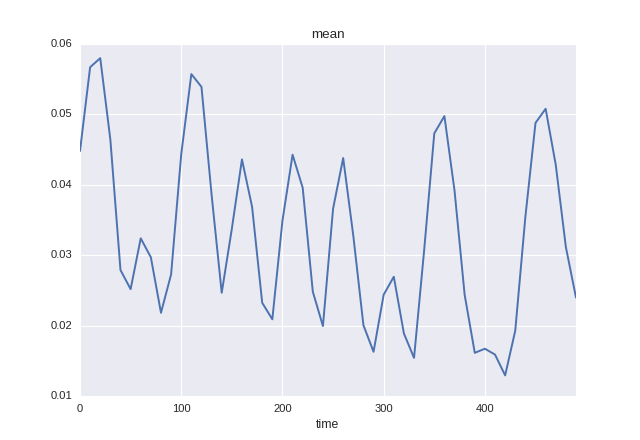

<IPython.core.display.Javascript object>


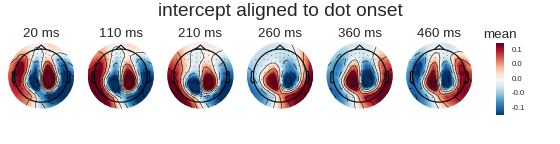

In [15]:
show_topology_at_peaks(second_level, 'intercept', 'mean', mode='absmean')

<IPython.core.display.Javascript object>


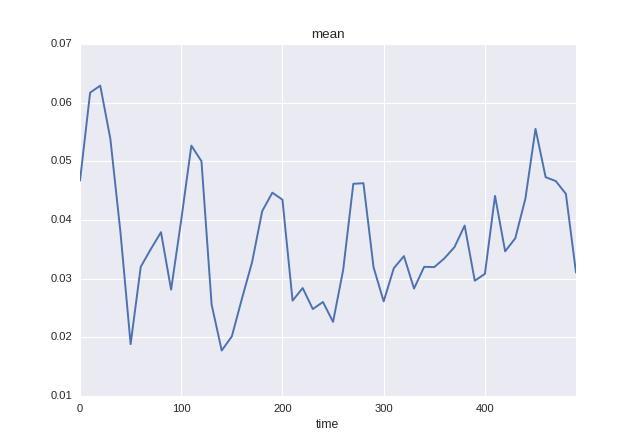

<IPython.core.display.Javascript object>


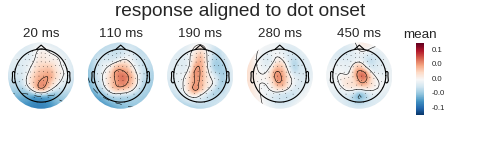

In [16]:
show_topology_at_peaks(second_level, 'response', 'mean')

# Check single subject results

In [6]:
first_level_diagnostics = pd.read_hdf(resfile, 'first_level_diagnostics')
first_level = pd.read_hdf(resfile, 'first_level')

In [12]:
first_level.columns.levels[1]

Index(['beta', 'bse'], dtype='object', name='measure')

In [16]:
sl2 = first_level.xs('beta', axis=1, level='measure').abs().mean(axis=1, level='regressor')
sl2.columns = pd.MultiIndex.from_product([['mean'], sl2.columns], names=['measure', 'regressor'])

In [17]:
sl2

measure                  mean                                           \
regressor           abs_dot_x abs_dot_y     accev accsur_pca     dot_x   
permnr channel time                                                      
0      MEG0111 0     0.022158  0.012504  0.024533   0.019484  0.019925   
               10    0.022488  0.012532  0.023444   0.019486  0.022248   
               20    0.022435  0.013733  0.024293   0.017851  0.017797   
               30    0.022644  0.015043  0.024593   0.019526  0.018390   
               40    0.023600  0.016181  0.026994   0.020993  0.022459   
               50    0.023433  0.016996  0.028071   0.020143  0.021211   
               60    0.024415  0.016914  0.032458   0.020104  0.019707   
               70    0.023440  0.015281  0.030786   0.020387  0.023479   
               80    0.022769  0.012878  0.026777   0.021327  0.021936   
               90    0.020980  0.013644  0.028592   0.021824  0.019572   
               100   0.020190  0.014850  0.027681   0.019746  0.017669   
               110   0.023361  0.016360  0.030478   0.018995  0.020706   
               120   0.024527  0.016010  0.034461   0.020332  0.023122   
               130   0.021414  0.014274  0.034417   0.019547  0.020442   
               140   0.017597  0.018806  0.033652   0.021554  0.024753   
               150   0.017374  0.024039  0.029476   0.021927  0.026715   
               160   0.018555  0.020946  0.031792   0.021616  0.028443   
               170   0.019754  0.021147  0.030950   0.022652  0.028036   
               180   0.019182  0.019710  0.033503   0.021616  0.028282   
               190   0.018583  0.017815  0.037354   0.021395  0.022876   
               200   0.017865  0.016684  0.038594   0.023677  0.021246   
               210   0.017156  0.015362  0.039711   0.027545  0.024445   
               220   0.017484  0.017648  0.041354   0.026696  0.027557   
               230   0.014749  0.021437  0.040499   0.022126  0.029691   
               240   0.016154  0.018396  0.033687   0.020626  0.026426   
               250   0.015876  0.019806  0.030013   0.019669  0.025245   
               260   0.018364  0.020088  0.034040   0.020611  0.024278   
               270   0.018079  0.016993  0.035319   0.022851  0.024178   
               280   0.021934  0.018374  0.036441   0.022122  0.025188   
               290   0.019908  0.022392  0.037218   0.020269  0.030143   
...                       ...       ...       ...        ...       ...   
5      MEG2641 200   0.022955  0.016129  0.020000   0.018347  0.015904   
               210   0.018303  0.017844  0.018402   0.018204  0.021340   
               220   0.022061  0.017334  0.016007   0.019140  0.014474   
               230   0.019969  0.017324  0.024013   0.018383  0.015008   
               240   0.021713  0.013452  0.016286   0.022685  0.016662   
               250   0.020280  0.013937  0.016386   0.020612  0.015531   
               260   0.025184  0.013193  0.016505   0.018598  0.018630   
               270   0.019006  0.017195  0.019143   0.017861  0.016480   
               280   0.020907  0.014484  0.014909   0.020747  0.018761   
               290   0.025323  0.015719  0.015030   0.017323  0.018526   
               300   0.020358  0.015214  0.020411   0.018700  0.017018   
               310   0.020996  0.017869  0.017199   0.013325  0.014941   
               320   0.019945  0.017449  0.017149   0.019696  0.017608   
               330   0.018963  0.017904  0.017821   0.018240  0.020135   
               340   0.015016  0.013771  0.015811   0.018444  0.019067   
               350   0.017917  0.015325  0.014546   0.018878  0.017495   
               360   0.019781  0.015261  0.016410   0.013542  0.020235   
               370   0.016964  0.019594  0.015949   0.017414  0.017642   
               380   0.017850  0.014603  0.015177   0.018865  0.013945   
               390   0.014656  0.013607  0.014239   0.015124  0.016424   
    

<IPython.core.display.Javascript object>


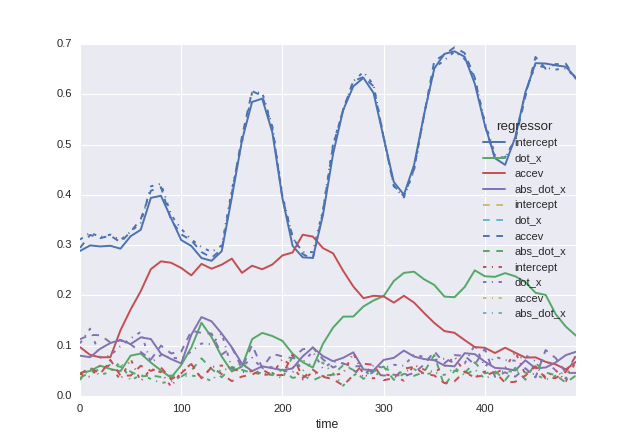

<IPython.core.display.Javascript object>


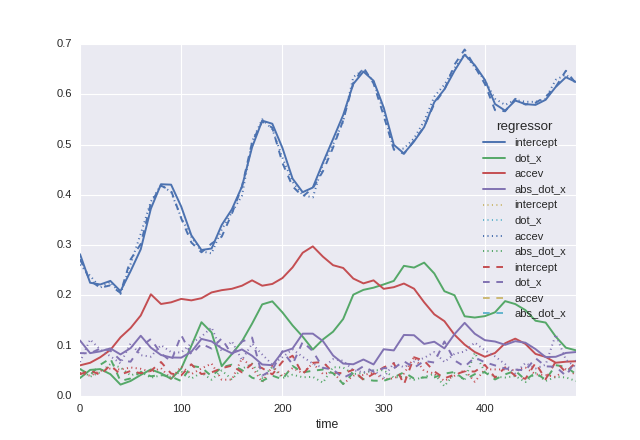

<IPython.core.display.Javascript object>


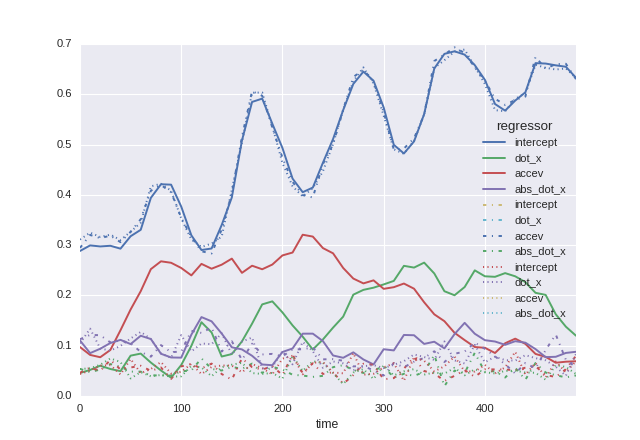

In [16]:
sub = 4
plot_minmax_regressors(first_level.xs(sub, level='subject', axis=1), 
                       reg, 'beta', nperm=2, mode='max')
plot_minmax_regressors(first_level.xs(sub, level='subject', axis=1), 
                       reg, 'beta', nperm=2, mode='min')
plot_minmax_regressors(first_level.xs(sub, level='subject', axis=1), 
                       reg, 'beta', nperm=2, mode='absmax')

## Determine relative 'power' of 20 and 60 ms peaks in intercept

In [17]:
times = first_level.index.levels[2]

# determine mean in 100 ms bins
for tbin in range(int(np.ceil(times[-1] / 100))):
    tbin_times = times[(times >= tbin * 100) & (times < (tbin+1) * 100)]
    
    binmean = first_level.loc[(0, slice(None), tbin_times), 
        (slice(None), 'beta', 'intercept')].abs().max(level='time').mean()
    
# first 200 ms


In [18]:
tbin=1
times = first_level.index.levels[2]
tbin_times = times[(times >= tbin * 100) & (times < (tbin+1) * 100)]
first_level.loc[(0, slice(None), tbin_times), (slice(None), 'beta', 'intercept')].abs().max(level='time').mean()

subject  measure  regressor
2        beta     intercept    0.389247
3        beta     intercept    0.264310
4        beta     intercept    0.424077
5        beta     intercept    0.432001
6        beta     intercept    0.558149
7        beta     intercept    0.336534
8        beta     intercept    0.398896
9        beta     intercept    0.399745
10       beta     intercept    0.294193
11       beta     intercept    0.296134
12       beta     intercept    0.620539
13       beta     intercept    0.384772
15       beta     intercept    0.426321
16       beta     intercept    0.557392
17       beta     intercept    0.504056
18       beta     intercept    0.559385
19       beta     intercept    0.409016
20       beta     intercept    0.470337
21       beta     intercept    0.324355
22       beta     intercept    0.394971
23       beta     intercept    0.330052
24       beta     intercept    0.417385
25       beta     intercept    0.604494
26       beta     intercept    0.555887
27       bet